In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from seaborn import heatmap

from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats import diagnostic as diag

plt.style.use('fivethirtyeight')

# Cleaning the data

dataset = pd.read_excel("mas_car_00_18_2019_adjusted.xlsx")

df = dataset[['Date Announced', 'Original Date Announced', 'Standard Industry Classification Code',
            'Same_industry', 'CAR(-1, +1)', 'CAR(-2, 2)', 'crossborderdeal', 'cashpayment', 'leverage',
            'Acquiror Market Value 4 Weeks Prior to Announcement ($mil).1', 'Deal Attitude', 'Deal Status',
            'Percentage of Shares Acquired', 'TPUBLIC', 'Target Market Value 4 Weeks Prior to Announcment ($mil)']]
df['Date (years)'] = pd.to_datetime(df['Date Announced'], format="%Y%m%d").dt.year

# rename the columns
column_mapping = {'Standard Industry Classification Code': 'SIC',
            'Same_industry': 'HORIZ', 'CAR(-2, 2)': 'CAR(-2, +2)',
            'crossborderdeal': 'CROSS', 'cashpayment': 'CASH', 'leverage': 'LEV',
            'Acquiror Market Value 4 Weeks Prior to Announcement ($mil).1': 'Acq_size',
            'TPUBLIC': 'Tar. Private', 'Target Market Value 4 Weeks Prior to Announcment ($mil)': 'DSIZE'}

df = df.rename(mapper=column_mapping, axis=1)

# drop date announced, original date announced
df = df.drop(['Date Announced', 'Original Date Announced'], axis=1)

# save new dataframe as a .csv file
df.to_csv('ARP_compressed_dataset.csv', index=False)

for col in dataset.columns:
    print(col)

# Filtering the sample

In [2]:
# reimport the data set
df = pd.read_csv('ARP_compressed_dataset.csv')
df

,SIC,HORIZ,"CAR(-1, +1)","CAR(-2, +2)",CROSS,CASH,LEV,Acq_size,Deal Attitude,Deal Status,Percentage of Shares Acquired,Tar. Private,DSIZE,Date (years)
0,5961,0,-0.001608,0.009858,0,0,0.456346,140.433,Friendly,Completed,36,Priv.,NaN,2013
1,5961,0,-0.018310,-0.034374,1,1,0.4521884,555.630,Friendly,Completed,100,Priv.,NaN,2008
2,5961,0,-0.007620,-0.015071,1,1,0.344419,426.282,Friendly,Completed,100,Sub.,NaN,2006
3,5961,0,0.211841,0.146537,1,1,0.3044112,330.046,Friendly,Completed,100,Public,137.544,2014
4,6020,0,0.001937,0.048450,1,0,0.9189009,57.730,Friendly,Completed,100,Priv.,NaN,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20371,6211,1,0.027444,0.020493,1,0,0.7598003,1333.872,Friendly,Pending,.,Sub.,NaN,2008
20372,6211,0,0.100135,0.151409,1,0,0.7244874,667.857,Friendly,Completed,100,Priv.,NaN,2009
20373,6211,0,0.039568,0.030297,1,0,0.7128826,1446.661,Friendly,Completed,100,Priv.,NaN,2007
20374,7372,0,-0.029043,0.003318,1,0,0.295371,355.064,Friendly,Completed,100,Priv.,NaN,2006


In [3]:
# categorise deals in terms of deal attitude
# remove deal attitude that is not applicable and unsolicit
df = df.loc[df['Deal Attitude'] != 'Not Appl.']
df = df.loc[df['Deal Attitude'] != 'Unsolic.']

# assign 1 to friendly deals and 0 to other deals
df.loc[:, 'Deal Attitude'].replace(to_replace={'Friendly': 1, 'Neutral': 0, 'Hostile': 0}, inplace=True)
df.reset_index(inplace=True, drop=True)

In [4]:
# assign 1 to private targets and 0 to other public status
df.loc[:, 'Tar. Private'].replace(to_replace={'Priv.': 1, 'Sub.': 0, 'Public': 0, 'J.V.': 0, 'Govt.': 0}, inplace=True)
df.reset_index(inplace=True, drop=True)

In [5]:
# convert data in acquired ownership into float
df = df[df['Percentage of Shares Acquired'] != '.']
df['Percentage of Shares Acquired'] = df['Percentage of Shares Acquired'].astype(np.float64)

In [6]:
# only select the completed deals
df = df.loc[df['Deal Status'] == 'Completed']
print(f"The number of observations is: {df.shape[0]}")

# only select the deals that over 50% ownership is acquired
df = df.loc[df['Percentage of Shares Acquired'] >= 50]
print(f"The number of observations is: {df.shape[0]}")

# only select the deals with non-null target market value
df = df.loc[df['DSIZE'].notnull()]
print(f"The number of observations is: {df.shape[0]}")

# drop these two columns
df.drop(columns=['Deal Status', 'Percentage of Shares Acquired'], inplace=True)

The number of observations is: 16871
The number of observations is: 16086
The number of observations is: 1227


In [7]:
# categorise high-tech companies in terms of the SIC code
# 3-digit optimal SIC code in Kile and Phillips (2009)
df['SIC'] = df['SIC'].astype(str)

high_tech_sic = [283, 357, 366, 367, 382, 384, 481, 482, 489, 737, 873]
ht_df = pd.DataFrame()

for sic in high_tech_sic:    
    ht_df = pd.concat([ht_df, df[df['SIC'].str.startswith(f'{sic}')]])

ht_df.reset_index(inplace=True, drop=True)

In [8]:
# only select the deals from 2006 to 2017
ht_df = ht_df.loc[(ht_df['Date (years)'] >= 2005) & (ht_df['Date (years)'] <= 2017)]

# delete unnecessary columns (SIC, Date)
ht_df = ht_df.drop(['SIC', 'Deal Attitude'], axis=1)

# reset the index
ht_df = ht_df.reset_index(drop=True)

In [9]:
# change the dtype of column 'LEV'
ht_df = ht_df.drop(ht_df.loc[ht_df['LEV'] == '.'].index)
ht_df['LEV'] = ht_df['LEV'].astype(float)
ht_df = ht_df.reset_index(drop=True)

In [10]:
# calculate the relative size of each transaction
ht_df['RSIZE'] = ht_df['DSIZE'] / ht_df['Acq_size']

In [11]:
# reorder the column
ht_df = ht_df[[
    'Date (years)', 'CAR(-1, +1)', 'CAR(-2, +2)', 'CROSS', 'CASH',
    'HORIZ', 'DSIZE', 'RSIZE', 'LEV', 'Acq_size', 'Tar. Private'
    ]]

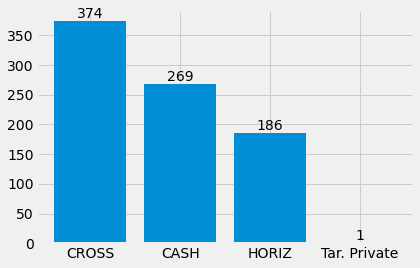

In [12]:
# visualise the distribution of categorical variables
x = ['CROSS', 'CASH', 'HORIZ', 'Tar. Private']
y = [ht_df[n].sum() for n in x]

plt.bar(x, y)
for i in range(len(y)):
    plt.annotate(str(y[i]), xy=(x[i], y[i]), ha='center', va='bottom')

plt.show()

In [13]:
# remove the Tar. private column
ht_df = ht_df.drop('Tar. Private', axis=1)

# reset the index
ht_df = ht_df.reset_index(drop=True)

In [14]:
# change Acq_size and DSIZE to their log value for scale smoothing
ht_df['Acq_size'] = np.log(ht_df.Acq_size)
ht_df['DSIZE'] = np.log(ht_df.DSIZE)


In [15]:
ht_df.to_csv('ARP_ht_data.csv', index=False)
ht_df

,Date (years),"CAR(-1, +1)","CAR(-2, +2)",CROSS,CASH,HORIZ,DSIZE,RSIZE,LEV,Acq_size
0,2015,-0.059092,-0.068087,1,1,0,9.439383,0.138620,0.936763,11.415402
1,2009,0.004792,0.055386,1,1,0,5.816590,0.004191,0.536660,11.291327
2,2014,-0.008882,0.011462,0,0,1,7.476291,0.030198,0.436201,10.976277
3,2010,0.018298,-0.007777,1,1,0,6.090807,0.005342,0.563140,11.322900
4,2009,-0.002918,-0.009315,0,0,0,4.188305,0.000795,0.571191,11.326012
...,...,...,...,...,...,...,...,...,...,...
447,2008,-0.014172,-0.030753,0,0,0,6.651629,0.024593,0.242955,10.356906
448,2007,0.010579,0.018269,1,0,0,3.241185,0.043071,0.693630,6.386089
449,2006,-0.059281,-0.080870,1,1,0,3.414837,0.053428,0.603128,6.344249
450,2006,0.024441,0.032589,1,1,0,0.501381,0.024208,0.645392,4.222474


# Separate the sample
- Cross border deals 
- National deals 

Analyse sub-samples descriptive statistics in terms of company characteristics

In [16]:
# split the sample
cross_df = ht_df[ht_df.CROSS == 1]
national_df = ht_df[ht_df.CROSS == 0]

In [17]:
# show the descriptive statistics for each one
cross_des = cross_df.drop(['Date (years)', 'CAR(-2, +2)', 'CROSS'], axis=1).describe()
cross_des.to_clipboard()

cross_des

,"CAR(-1, +1)",CASH,HORIZ,DSIZE,RSIZE,LEV,Acq_size
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,-0.007172,0.590909,0.441176,5.605409,0.510757,0.474866,8.530977
std,0.072925,0.492325,0.497193,2.017028,5.978594,0.264066,2.319889
min,-0.330750,0.000000,0.000000,-3.194183,0.000011,0.034233,0.564177
25%,-0.035539,0.000000,0.000000,4.244865,0.015800,0.312079,6.712953
50%,-0.002862,1.000000,0.000000,5.682663,0.067847,0.455397,8.437853
75%,0.022443,1.000000,1.000000,6.973771,0.230231,0.602052,10.372869
max,0.264029,1.000000,1.000000,10.781452,115.630830,2.758185,13.213017


In [18]:
national_des = national_df.drop(['Date (years)', 'CAR(-2, +2)', 'CROSS'], axis=1).describe()
national_des.to_clipboard()

national_des

,"CAR(-1, +1)",CASH,HORIZ,DSIZE,RSIZE,LEV,Acq_size
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,0.014908,0.615385,0.269231,5.140672,0.165313,0.439731,8.142257
std,0.065130,0.489653,0.446431,1.876765,0.287192,0.212259,2.111666
min,-0.138915,0.000000,0.000000,0.416735,0.000795,0.068770,1.800389
25%,-0.013988,0.000000,0.000000,3.669448,0.016345,0.262420,6.921015
50%,0.010067,1.000000,0.000000,5.190001,0.071166,0.454853,8.086329
75%,0.028367,1.000000,1.000000,6.469375,0.200453,0.574811,9.535363
max,0.270624,1.000000,1.000000,9.419559,1.982565,1.018791,12.673011


In [19]:
# test for multicollinearity
X1 = sm.tools.add_constant(ht_df.drop(['Date (years)', 'CAR(-1, +1)'], axis=1))
vif = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)
vif_df = vif.to_frame()
vif_df.to_clipboard()

vif_df

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,0
const,21.267850
"CAR(-2, +2)",1.064229
CROSS,1.046168
CASH,1.208812
HORIZ,1.057710
DSIZE,1.619456
RSIZE,1.064140
LEV,1.050963
Acq_size,1.910556


# Empirical analysis
- Univariate test
- Multivariate test

## Univariate test

In [20]:
# t-test for cross-border and domestic samples
cross = ht_df['CAR(-1, +1)'].loc[ht_df['CROSS'] == 1]
domestic = ht_df['CAR(-1, +1)'].loc[ht_df['CROSS'] == 0]
one_day_car_cross = ttest_ind(x1=cross, x2=domestic, usevar='unequal')

print(f"""
    The t-statistics is: {one_day_car_cross[0]:.3f}
    The p-value is: {one_day_car_cross[1] / 2:.3f}
    The degree of freedom is {one_day_car_cross[2]:.3f}
    """)


    The t-statistics is: -2.666
    The p-value is: 0.004
    The degree of freedom is 120.824
    


In [21]:
cross = ht_df['CAR(-2, +2)'].loc[ht_df['CROSS'] == 1]
domestic = ht_df['CAR(-2, +2)'].loc[ht_df['CROSS'] == 0]
two_day_car_cross = ttest_ind(x1=cross, x2=domestic, usevar='unequal')

print(f"""
    The t-statistics is: {two_day_car_cross[0]:.3f}
    The p-value is: {two_day_car_cross[1] / 2:.3f}
    The degree of freedom is {two_day_car_cross[2]:.3f}""")


    The t-statistics is: -2.430
    The p-value is: 0.008
    The degree of freedom is 114.575


In [22]:
# t-test for cash and non-cash observations
cash = ht_df['CAR(-1, +1)'].loc[ht_df['CASH'] == 1]
non_cash = ht_df['CAR(-1, +1)'].loc[ht_df['CASH'] == 0]
one_day_car_cash = ttest_ind(x1=cash, x2=non_cash, usevar='unequal')

print(f"""
    The t-statistics is: {one_day_car_cash[0]:.3f}
    The p-value is: {one_day_car_cash[1] / 2:.3f}
    The degree of freedom is {one_day_car_cash[2]:.3f}""")


    The t-statistics is: 2.015
    The p-value is: 0.022
    The degree of freedom is 256.145


In [41]:
cash = ht_df['CAR(-2, +2)'].loc[ht_df['CASH'] == 1]
non_cash = ht_df['CAR(-2, +2)'].loc[ht_df['CASH'] == 0]
two_day_car_cash = ttest_ind(x1=cash, x2=non_cash, usevar='unequal')

print(f"""
    The t-statistics is: {two_day_car_cash[0]:.3f}
    The p-value is: {two_day_car_cash[1] / 2:.3f}
    The degree of freedom is {two_day_car_cash[2]:.3f}""")


    The t-statistics is: 2.312
    The p-value is: 0.011
    The degree of freedom is 260.637


## Mutivariate test

In [24]:
# descriptive statistics of the sample
descriptive_df = ht_df.describe()

# save the table
descriptive_df.to_csv('tables_for_use/descriptive_statistics.csv')

descriptive_df

,Date (years),"CAR(-1, +1)","CAR(-2, +2)",CROSS,CASH,HORIZ,DSIZE,RSIZE,LEV,Acq_size
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000
mean,2010.194690,-0.003361,-0.004979,0.827434,0.595133,0.411504,5.525211,0.451145,0.468803,8.463897
std,3.073695,0.072058,0.082718,0.378291,0.491410,0.492651,1.999261,5.439938,0.256008,2.287801
min,2005.000000,-0.330750,-0.368057,0.000000,0.000000,0.000000,-3.194183,0.000011,0.034233,0.564177
25%,2008.000000,-0.028850,-0.032935,1.000000,0.000000,0.000000,4.190056,0.015947,0.301691,6.740203
50%,2010.000000,-0.002362,-0.003933,1.000000,1.000000,0.000000,5.602198,0.068305,0.455397,8.337667
75%,2013.000000,0.023812,0.027444,1.000000,1.000000,1.000000,6.901908,0.220401,0.594697,10.280310
max,2016.000000,0.270624,0.315561,1.000000,1.000000,1.000000,10.781452,115.630830,2.758185,13.213017


In [25]:
# correlation matirx of the sample
correlation_df = ht_df.drop(['CAR(-2, +2)', 'Date (years)'], axis=1).corr()

# save the table
correlation_df.to_csv('tables_for_use/correlation.csv')

correlation_df

,"CAR(-1, +1)",CROSS,CASH,HORIZ,DSIZE,RSIZE,LEV,Acq_size
"CAR(-1, +1)",1.000000,-0.115914,0.104763,0.133021,0.079656,-0.086554,-0.011162,0.115587
CROSS,-0.115914,1.000000,-0.018841,0.132031,0.087935,0.024022,0.051917,0.064275
CASH,0.104763,-0.018841,1.000000,-0.042998,0.048006,-0.078159,-0.074334,0.342946
HORIZ,0.133021,0.132031,-0.042998,1.000000,0.090335,-0.040476,-0.003052,-0.011091
DSIZE,0.079656,0.087935,0.048006,0.090335,1.000000,0.009495,0.114411,0.577462
RSIZE,-0.086554,0.024022,-0.078159,-0.040476,0.009495,1.000000,-0.016261,-0.184838
LEV,-0.011162,0.051917,-0.074334,-0.003052,0.114411,-0.016261,1.000000,0.148323
Acq_size,0.115587,0.064275,0.342946,-0.011091,0.577462,-0.184838,0.148323,1.000000


<AxesSubplot:>

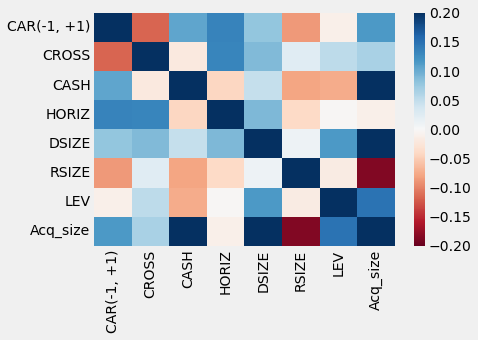

In [26]:
heatmap(correlation_df, cmap='RdBu', vmin=-0.2, vmax=0.2)

In [27]:
ht_df

,Date (years),"CAR(-1, +1)","CAR(-2, +2)",CROSS,CASH,HORIZ,DSIZE,RSIZE,LEV,Acq_size
0,2015,-0.059092,-0.068087,1,1,0,9.439383,0.138620,0.936763,11.415402
1,2009,0.004792,0.055386,1,1,0,5.816590,0.004191,0.536660,11.291327
2,2014,-0.008882,0.011462,0,0,1,7.476291,0.030198,0.436201,10.976277
3,2010,0.018298,-0.007777,1,1,0,6.090807,0.005342,0.563140,11.322900
4,2009,-0.002918,-0.009315,0,0,0,4.188305,0.000795,0.571191,11.326012
...,...,...,...,...,...,...,...,...,...,...
447,2008,-0.014172,-0.030753,0,0,0,6.651629,0.024593,0.242955,10.356906
448,2007,0.010579,0.018269,1,0,0,3.241185,0.043071,0.693630,6.386089
449,2006,-0.059281,-0.080870,1,1,0,3.414837,0.053428,0.603128,6.344249
450,2006,0.024441,0.032589,1,1,0,0.501381,0.024208,0.645392,4.222474


In [28]:
# multilinear regression of 1-day CAR - all variables
y = ht_df['CAR(-1, +1)']
X = ht_df.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

results.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CAR(-1, +1)   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     4.081
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           0.000235
Time:                        14:14:41   Log-Likelihood:                 562.12
No. Observations:                 452   AIC:                            -1108.
Df Residuals:                     444   BIC:                            -1075.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0209      0.015     -1.367      0.172      -0.051       0.009
CROSS         -0.0266      0.009     -2.998      0.003      -0.044      -0.009
CASH           0.0113      0.007      1.535      0.126      -0.003       0.026
HORIZ          0.0219      0.007      3.201      0.001       0.008       0.035
DSIZE          0.0013      0.002      0.624      0.533      -0.003       0.005
RSIZE         -0.0008      0.001     -1.239      0.216      -0.002       0.000
LEV           -0.0037      0.013     -0.280      0.779      -0.030       0.022
Acq_size       0.0022      0.002      1.098      0.273      -0.002       0.006
==============================================================================
Omnibus:                       53.415   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              349.324
Skew:                           0.183   Prob(JB):                     1.40e-76
Kurtosis:                       7.291   Cond. No.                         53.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
# multilinear regression of 1-day CAR - control variables
# Model 1
y = ht_df['CAR(-1, +1)']
X = ht_df.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'CASH', 'CROSS', 'HORIZ'], axis=1)
X = sm.add_constant(X)

y2 = ht_df['CAR(-2, +2)']
X2 = ht_df.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'CASH', 'CROSS', 'HORIZ'], axis=1)
X2 = sm.add_constant(X2)

# 3-day window
model = sm.OLS(y, X)
model1 = model.fit()

# 5-day window
five_day_model = sm.OLS(y2, X2)
five_day_model1 = five_day_model.fit()

model1.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CAR(-1, +1)   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.193
Date:                Mon, 23 Aug 2021   Prob (F-statistic):             0.0689
Time:                        14:14:41   Log-Likelihood:                 552.42
No. Observations:                 452   AIC:                            -1095.
Df Residuals:                     447   BIC:                            -1074.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0290      0.014     -2.067      0.039      -0.057      -0.001
DSIZE          0.0012      0.002      0.569      0.569      -0.003       0.005
RSIZE         -0.0009      0.001     -1.477      0.140      -0.002       0.000
LEV           -0.0082      0.013     -0.614      0.540      -0.034       0.018
Acq_size       0.0028      0.002      1.479      0.140      -0.001       0.006
==============================================================================
Omnibus:                       50.175   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.021
Skew:                           0.092   Prob(JB):                     1.60e-71
Kurtosis:                       7.157   Cond. No.                         48.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
# CROSS
# Model 2
y = ht_df['CAR(-1, +1)']
X = ht_df.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'CASH', 'HORIZ'], axis=1)
X = sm.add_constant(X)

y2 = ht_df['CAR(-2, +2)']
X2 = ht_df.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'CASH', 'HORIZ'], axis=1)
X2 = sm.add_constant(X2)

# 3-day window
model = sm.OLS(y, X)
model2 = model.fit()

# 5-day window
five_day_model = sm.OLS(y2, X2)
five_day_model2 = five_day_model.fit()

model2.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CAR(-1, +1)   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.149
Date:                Mon, 23 Aug 2021   Prob (F-statistic):            0.00834
Time:                        14:14:41   Log-Likelihood:                 555.87
No. Observations:                 452   AIC:                            -1100.
Df Residuals:                     446   BIC:                            -1075.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0129      0.015     -0.844      0.399      -0.043       0.017
CROSS         -0.0233      0.009     -2.619      0.009      -0.041      -0.006
DSIZE          0.0015      0.002      0.720      0.472      -0.003       0.006
RSIZE         -0.0009      0.001     -1.413      0.158      -0.002       0.000
LEV           -0.0068      0.013     -0.511      0.610      -0.033       0.019
Acq_size       0.0029      0.002      1.537      0.125      -0.001       0.006
==============================================================================
Omnibus:                       50.054   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              316.560
Skew:                           0.124   Prob(JB):                     1.82e-69
Kurtosis:                       7.092   Cond. No.                         52.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# multilinear regression of 2-day CAR
y = ht_df['CAR(-2, +2)']
X = ht_df.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

results.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CAR(-2, +2)   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     4.074
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           0.000240
Time:                        14:14:41   Log-Likelihood:                 499.74
No. Observations:                 452   AIC:                            -983.5
Df Residuals:                     444   BIC:                            -950.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0140      0.018     -0.796      0.426      -0.048       0.020
CROSS         -0.0283      0.010     -2.777      0.006      -0.048      -0.008
CASH           0.0151      0.008      1.785      0.075      -0.002       0.032
HORIZ          0.0241      0.008      3.067      0.002       0.009       0.040
DSIZE          0.0011      0.002      0.436      0.663      -0.004       0.006
RSIZE         -0.0005      0.001     -0.633      0.527      -0.002       0.001
LEV           -0.0277      0.015     -1.824      0.069      -0.058       0.002
Acq_size       0.0025      0.002      1.072      0.284      -0.002       0.007
==============================================================================
Omnibus:                       41.902   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.395
Skew:                          -0.156   Prob(JB):                     1.12e-44
Kurtosis:                       6.263   Cond. No.                         53.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
# CROSS * HORIZ
# Model 4
horiz_interact = ht_df.copy()
# horiz_interact['CROSS * HORIZ'] = horiz_interact.CROSS * horiz_interact.HORIZ

y = horiz_interact['CAR(-1, +1)']
X = horiz_interact.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'CASH'], axis=1)
X = sm.add_constant(X)

y2 = horiz_interact['CAR(-2, +2)']
X2 = horiz_interact.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'CASH'], axis=1)
X2 = sm.add_constant(X2)

# 3-day window
model = sm.OLS(y, X)
model4 = model.fit()

# 5-day window
five_day_model = sm.OLS(y2, X2)
five_day_model4 = five_day_model.fit()

model4.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CAR(-1, +1)   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     4.355
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           0.000275
Time:                        14:14:41   Log-Likelihood:                 560.93
No. Observations:                 452   AIC:                            -1108.
Df Residuals:                     445   BIC:                            -1079.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0193      0.015     -1.265      0.207      -0.049       0.011
CROSS         -0.0270      0.009     -3.033      0.003      -0.044      -0.009
HORIZ          0.0218      0.007      3.173      0.002       0.008       0.035
DSIZE          0.0007      0.002      0.341      0.733      -0.003       0.005
RSIZE         -0.0008      0.001     -1.216      0.224      -0.002       0.000
LEV           -0.0063      0.013     -0.482      0.630      -0.032       0.019
Acq_size       0.0034      0.002      1.838      0.067      -0.000       0.007
==============================================================================
Omnibus:                       50.153   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              316.534
Skew:                           0.129   Prob(JB):                     1.84e-69
Kurtosis:                       7.092   Cond. No.                         52.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# CROSS * CASH
# Model 3
cash_interact = ht_df.copy()
cash_interact['CROSS * CASH'] = cash_interact.CROSS * cash_interact.CASH

y = cash_interact['CAR(-1, +1)']
X = cash_interact.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'HORIZ'], axis=1)
X = sm.add_constant(X)

y2 = cash_interact['CAR(-2, +2)']
X2 = cash_interact.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'HORIZ'], axis=1)
X2 = sm.add_constant(X2)

# e-day window
model = sm.OLS(y, X)
model3 = model.fit()

# 5-day window
five_day_model = sm.OLS(y2, X2)
five_day_model3 = five_day_model.fit()

five_day_model3.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CAR(-2, +2)   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2.728
Date:                Mon, 23 Aug 2021   Prob (F-statistic):            0.00883
Time:                        14:15:10   Log-Likelihood:                 495.18
No. Observations:                 452   AIC:                            -974.4
Df Residuals:                     444   BIC:                            -941.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.021      0.010      0.992      -0.041       0.042
CROSS           -0.0320      0.016     -1.958      0.051      -0.064       0.000
CASH             0.0044      0.019      0.228      0.820      -0.033       0.042
DSIZE            0.0019      0.002      0.765      0.445      -0.003       0.007
RSIZE           -0.0006      0.001     -0.817      0.414      -0.002       0.001
LEV             -0.0278      0.015     -1.808      0.071      -0.058       0.002
Acq_size         0.0018      0.002      0.792      0.429      -0.003       0.006
CROSS * CASH     0.0127      0.021      0.604      0.546      -0.029       0.054
==============================================================================
Omnibus:                       42.128   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.815
Skew:                          -0.123   Prob(JB):                     1.01e-46
Kurtosis:                       6.345   Cond. No.                         93.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# Acq_size * HORIZ interaction
# Model 5

horiz_interact = ht_df.copy()
horiz_interact['SIZE * HORIZ'] = horiz_interact.Acq_size * horiz_interact.HORIZ

y = horiz_interact['CAR(-1, +1)']
X = horiz_interact.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'CASH'], axis=1)
X = sm.add_constant(X)

y2 = horiz_interact['CAR(-2, +2)']
X2 = horiz_interact.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)', 'CASH'], axis=1)
X2 = sm.add_constant(X2)

# e-day window
model = sm.OLS(y, X)
model5 = model.fit()

# 5-day window
five_day_model = sm.OLS(y2, X2)
five_day_model5 = five_day_model.fit()

model5.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CAR(-1, +1)   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     3.853
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           0.000440
Time:                        14:14:41   Log-Likelihood:                 561.36
No. Observations:                 452   AIC:                            -1107.
Df Residuals:                     444   BIC:                            -1074.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0280      0.018     -1.560      0.119      -0.063       0.007
CROSS           -0.0267      0.009     -2.996      0.003      -0.044      -0.009
HORIZ            0.0460      0.027      1.691      0.092      -0.007       0.099
DSIZE            0.0009      0.002      0.424      0.672      -0.003       0.005
RSIZE           -0.0007      0.001     -1.111      0.267      -0.002       0.001
LEV             -0.0063      0.013     -0.480      0.632      -0.032       0.020
Acq_size         0.0043      0.002      2.055      0.040       0.000       0.008
SIZE * HORIZ    -0.0029      0.003     -0.920      0.358      -0.009       0.003
==============================================================================
Omnibus:                       50.682   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.528
Skew:                           0.126   Prob(JB):                     2.05e-71
Kurtosis:                       7.150   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model diagnostics - Checking for heteroscedasticity

### White test and Breusch-Pagan test

In [35]:
# White test for models with dependent variable of CAR(-1, +1)
models = [model1, model2, model3, model4, model5]

for i, m in enumerate(models):
    _, pval, __, f_pval = diag.het_white(m.resid, m.model.exog)
    print(pval, f_pval)
    print('-'*100)

    print(f'The following is the White test results for model {i + 1}')
    if pval > 0.05:
        print("For the White's Test")
        print("The p-value was {:.4}".format(pval))
        print("We fail to reject the null hypthoesis, so there is no heterosecdasticity. \n")
        
    else:
        print("For the White's Test")
        print("The p-value was {:.4}".format(pval))
        print("We reject the null hypthoesis, so there is heterosecdasticity. \n")

5.215009243122236e-13 1.464387033633286e-14
----------------------------------------------------------------------------------------------------
The following is the White test results for model 1
For the White's Test
The p-value was 5.215e-13
We reject the null hypthoesis, so there is heterosecdasticity. 

4.700831132665876e-13 6.486265470259335e-15
----------------------------------------------------------------------------------------------------
The following is the White test results for model 2
For the White's Test
The p-value was 4.701e-13
We reject the null hypthoesis, so there is heterosecdasticity. 

9.986794322894776e-12 9.687612752037188e-14
----------------------------------------------------------------------------------------------------
The following is the White test results for model 3
For the White's Test
The p-value was 9.987e-12
We reject the null hypthoesis, so there is heterosecdasticity. 

6.45383458504313e-11 1.6734758018168397e-12
-----------------------------

In [36]:
# White test for models with dependent variable of CAR(-2, +2)
models = [five_day_model1, five_day_model2, five_day_model3, five_day_model4, five_day_model5]

for i, m in enumerate(models):
    _, pval, __, f_pval = diag.het_white(m.resid, m.model.exog)
    print(pval, f_pval)
    print('-'*100)

    print(f'The following is the White test results for model {i + 1}')
    if pval > 0.05:
        print("For the White's Test")
        print("The p-value was {:.4}".format(pval))
        print("We fail to reject the null hypthoesis, so there is no heterosecdasticity. \n")
        
    else:
        print("For the White's Test")
        print("The p-value was {:.4}".format(pval))
        print("We reject the null hypthoesis, so there is heterosecdasticity. \n")

1.0699815304566398e-12 3.551892970243716e-14
----------------------------------------------------------------------------------------------------
The following is the White test results for model 1
For the White's Test
The p-value was 1.07e-12
We reject the null hypthoesis, so there is heterosecdasticity. 

1.8507493487436883e-12 3.6858674823376384e-14
----------------------------------------------------------------------------------------------------
The following is the White test results for model 2
For the White's Test
The p-value was 1.851e-12
We reject the null hypthoesis, so there is heterosecdasticity. 

1.358123897205224e-11 1.4513539077060902e-13
----------------------------------------------------------------------------------------------------
The following is the White test results for model 3
For the White's Test
The p-value was 1.358e-11
We reject the null hypthoesis, so there is heterosecdasticity. 

1.4832791310446983e-10 4.80295115952619e-12
--------------------------

### Engle LM test

In [37]:
# Engle LM test for models with dependent variable of CAR(-1, +1)
models = [model1, model2, model3, model4, model5]

for i, m in enumerate(models):
    # Run the Engle LM test
    _, pval, __, f_pval = diag.het_arch(m.resid)
    print(pval, f_pval)
    print('-'*100)

    # print the results of the test
    print(f'The following is the results of Engle LM test for model {i + 1}')
    if pval > 0.05:
        print("For the Engle LM Test")
        print("The p-value was {:.4}".format(pval))
        print("We fail to reject the null hypthoesis, so there is no heterosecdasticity. \n")
        
    else:
        print("For the Engle LM Test")
        print("The p-value was {:.4}".format(pval))
        print("We reject the null hypthoesis, so there is heterosecdasticity. \n")

0.9132509120807439 0.9185077737229492
----------------------------------------------------------------------------------------------------
The following is the results of Engle LM test for model 1
For the Engle LM Test
The p-value was 0.9133
We fail to reject the null hypthoesis, so there is no heterosecdasticity. 

0.9004129028510968 0.9061328089202689
----------------------------------------------------------------------------------------------------
The following is the results of Engle LM test for model 2
For the Engle LM Test
The p-value was 0.9004
We fail to reject the null hypthoesis, so there is no heterosecdasticity. 

0.8857234521473328 0.8919162786645436
----------------------------------------------------------------------------------------------------
The following is the results of Engle LM test for model 3
For the Engle LM Test
The p-value was 0.8857
We fail to reject the null hypthoesis, so there is no heterosecdasticity. 

0.8813500335979174 0.8876728289878577
--------

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:657: FutureWarning: The default value of nlags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setmaxlags or period to silence this warning.
  warnings.warn("The default value of nlags is changing.  After 0.12, "


In [38]:
# Engle LM test for models with dependent variable of CAR(-2, +2)
models = [five_day_model1, five_day_model2, five_day_model3, five_day_model4, five_day_model5]

for i, m in enumerate(models):
    # Run the Engle LM test
    _, pval, __, f_pval = diag.het_arch(m.resid)
    print(pval, f_pval)
    print('-'*100)

    # print the results of the test
    print(f'The following is the results of Engle LM test for model {i + 1}')
    if pval > 0.05:
        print("For the Engle LM Test")
        print("The p-value was {:.4}".format(pval))
        print("We fail to reject the null hypthoesis, so there is no heterosecdasticity. \n")
        
    else:
        print("For the Engle LM Test")
        print("The p-value was {:.4}".format(pval))
        print("We reject the null hypthoesis, so there is heterosecdasticity. \n")

0.3772762405740727 0.3810369535652741
----------------------------------------------------------------------------------------------------
The following is the results of Engle LM test for model 1
For the Engle LM Test
The p-value was 0.3773
We fail to reject the null hypthoesis, so there is no heterosecdasticity. 

0.4040229926057828 0.4084370647909996
----------------------------------------------------------------------------------------------------
The following is the results of Engle LM test for model 2
For the Engle LM Test
The p-value was 0.404
We fail to reject the null hypthoesis, so there is no heterosecdasticity. 

0.46113077472954256 0.46683016166906555
----------------------------------------------------------------------------------------------------
The following is the results of Engle LM test for model 3
For the Engle LM Test
The p-value was 0.4611
We fail to reject the null hypthoesis, so there is no heterosecdasticity. 

0.547171053289047 0.5544421397647346
--------